This script test the impact of using different types of spectral constraints to estimate the desired graph. Graphs are generated as grid graphs where each node has 4 neighbors except those nodes on the borders. The error of the recovered graph is computed as the number of samples increases.

In [1]:
import cvxpy as cp
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import time
from joblib import Parallel, delayed
from os import cpu_count

import src.utils as utils

SEED = 0
N_CPUS = cpu_count()
np.random.seed(SEED)

## Auxiliary functions

In [16]:
def est_graph(id, models, MM, L, iters):
    X = utils.create_signals(L, MM[-1])

    N = X.shape[0]
    A_hat = np.zeros((N, N, len(models), len(MM)))
    lamd_hat = np.zeros((N, len(models), len(MM)))
    for i, M in enumerate(MM):
        C_hat = X[:,:M]@X[:,:M].T/M

        # Individual standard constraints
        for j, model in enumerate(models):
            t = time.time()
            L_hat, lamd_hat[:,j,i] = utils.est_graph(C_hat, model, iters) 
            A_hat[:,:,j,i] = np.diag(np.diag(L_hat)) - L_hat
            t = time.time() - t
            print('Cov-{}, M-{}: Model: {} - Time(sec): {:.3}'.format(id, M, model['name'], t))
    return A_hat, lamd_hat


def est_errs1(A_hat, lamd_hat, A, lambdas):
    L = np.diag(np.sum(A,0)) - A
    norm_A = np.linalg.norm(A,'fro')
    norm_lamb = np.linalg.norm(lambdas)
    norm_L = np.linalg.norm(L,'fro')
    
    err_A = np.zeros(A_hat.shape[2:])
    err_L = np.zeros(A_hat.shape[2:])
    err_lamb = np.zeros(A_hat.shape[2:])
    for k in range(A_hat.shape[-1]):
        for i in range(A_hat.shape[-2]):
            for j in range(A_hat.shape[-3]):
                L_hat = np.diag(np.sum(A_hat[:,:,j,i,k],0)) - A_hat[:,:,j,i,k]

                err_A[j,i,k] = np.linalg.norm(A-A_hat[:,:,j,i,k],'fro')**2/norm_A**2
                err_L[j,i,k] = np.linalg.norm(L-L_hat,'fro')**2/norm_L**2
                err_lamb[j,i,k] = np.linalg.norm(lambdas-lamd_hat[:,j,i,k],2)**2/norm_lamb**2
    return err_A, err_L, err_lamb


def est_errs2(A_hat, lamd_hat, A, lambdas):
    L = np.diag(np.sum(A,0)) - A
    norm_A = np.linalg.norm(A,'fro')
    norm_lamb = np.linalg.norm(lambdas)
    norm_L = np.linalg.norm(L,'fro')

    err_A = np.zeros(A_hat.shape[2:])
    err_lamb = np.zeros(A_hat.shape[2:])
    err_L = np.zeros(A_hat.shape[2:])
    for k in range(A_hat.shape[-1]):
        for i in range(A_hat.shape[-2]):
            for j in range(A_hat.shape[-3]):
                L_hat = np.diag(np.sum(A_hat[:,:,j,i,k],0)) - A_hat[:,:,j,i,k]
                if np.all((A_hat[:,:,j,i,k] == 0)):
                    norm_A_hat = 1
                    norm_L_hat = 1
                    norm_lamb_hat = 1
                else:
                    norm_A_hat = np.linalg.norm(A_hat[:,:,j,i,k], 'fro')
                    norm_L_hat = np.linalg.norm(L_hat, 'fro')
                    norm_lamb_hat = np.linalg.norm(lamd_hat[:,j,i,k], 2)

                A_hat_norm = A_hat[:,:,j,i,k]/norm_A_hat
                L_hat_norm = L_hat/norm_L_hat
                lam_hat_norm = lamd_hat[:,j,i,k]/norm_lamb_hat
                err_A[j,i,k] = np.linalg.norm(A/norm_A-A_hat_norm,'fro')**2
                err_L[j,i,k] = np.linalg.norm(L/norm_L-L_hat_norm,'fro')**2
                err_lamb[j,i,k] = np.linalg.norm(lambdas/norm_lamb-lam_hat_norm, 2)**2
    return err_A, err_L, err_lamb


def plot_err(MM, models, err, ylab, semlogy=True, ylim=[]):
    plt.figure()
    for i, model in enumerate(models):
        if semlogy:
            plt.semilogy(MM, err[i,:], model['fmt'], label=model['name'],
                        linewidth=2, markersize=12)
        else:
            plt.plot(MM, err[i,:], model['fmt'], label=model['name'],
                     linewidth=2, markersize=12)
        plt.grid(True)
        plt.xlabel('Number of samples')
        plt.ylabel(ylab)
        plt.legend()
        plt.xlim([MM[0], MM[-1]])
        if ylim:
            plt.ylim(ylim)
        plt.tight_layout()


def print_err(MM, models, err):
    mean_err = np.mean(err, 2)
    std = np.std(err, 2)
    for i, M in enumerate(MM):
        print('M:', M)
        for j, model in enumerate(models):
            print('\t{}: mean err: {:.6f} - std: {:.6f}'.
                   format(model['name'], mean_err[j,i], std[j,i]))


def plot_spectrum(models, lambdas, lambdas0, lamds_hat, M, grid=False, save=False):
    n_bins = np.arange(0,np.amax(lamds_hat)+1, 1)

    if grid:
        fig, axs = plt.subplots(2, 4, sharey=True, constrained_layout=True)
        axs[0,0].hist(lambdas, density=True, bins=n_bins)
        axs[0,0].set_title('True spectrum')
        axs[1,0].hist(lambdas0, density=True, bins=n_bins)
        axs[1,0].set_title('Ref spectrum')
        axs[0,1].hist(lamds_hat[:,0], density=True, bins=n_bins)
        axs[0,1].set_title(models[0]['name'])
        axs[0,2].hist(lamds_hat[:,3], density=True, bins=n_bins)
        axs[0,2].set_title(models[3]['name'])
        axs[0,3].hist(lamds_hat[:,4], density=True, bins=n_bins)
        axs[0,3].set_title(models[4]['name'])
        axs[1,1].hist(lamds_hat[:,1], density=True, bins=n_bins)
        axs[1,1].set_title(models[1]['name'])
        axs[1,2].hist(lamds_hat[:,2], density=True, bins=n_bins)
        axs[1,2].set_title(models[2]['name'])
        axs[1,3].hist(lamds_hat[:,5], density=True, bins=n_bins)
        axs[1,3].set_title(models[5]['name'])
        fig.suptitle('M=' + str(M))
    else:
        for i in range(lamds_hat.shape[1]+2):
            if i == 0:
                title = 'True spectrum'
                lambds_plt = lambdas
                sufix = 'true'
            elif i == 1:
                title = 'Ref spectrum'
                sufix = 'ref'
                lambds_plt = lambdas0
            else: 
                # title = '{}) {}'.format(chr(ord('a') + i), models[i-2]['name'])
                title = models[i-2]['name']
                lambds_plt = lamds_hat[:,i-2]
                sufix = models[i-2]['name'].lower()

            plt.figure()
            plt.hist(lambds_plt, density=True, bins=n_bins)
            plt.xlabel(title)
            plt.ylim([0, .25])
            plt.tight_layout()

            # if save:
            #     plt.savefig('{}spectrum_{}M_{}iters_{}.pdf'.format(PATH, M, iters, sufix))
            #     plt.savefig('{}spectrum_{}M_{}iters_{}.eps'.format(PATH, M, iters, sufix))

## Create graphs

Norm of A: 27.202941017470888
Norm of lambdas: 59.39696961966998


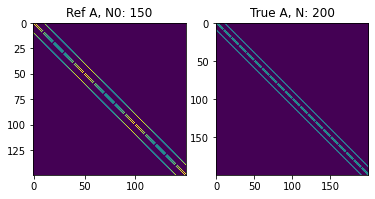

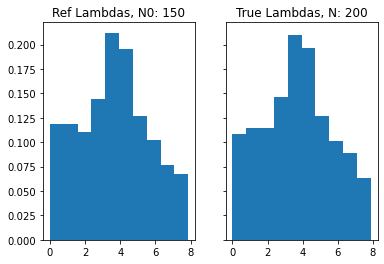

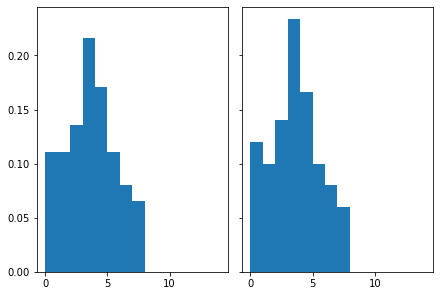

In [3]:
# Ref grap
n01 = 15
n02 = 10
N0 = n01*n02
A0 = nx.to_numpy_array(nx.grid_2d_graph(n01, n02))
L0 = np.diag(np.sum(A0, 0)) - A0
lambdas0, _ = np.linalg.eigh(L0)

# Target graph
n1 = 20
n2 = 10
N = n1*n2
A = nx.to_numpy_array(nx.grid_2d_graph(n1, n2))
L = np.diag(np.sum(A, 0)) - A
lambdas, V = np.linalg.eigh(L)

norm_A = np.linalg.norm(A,'fro')
norm_lamb = np.linalg.norm(lambdas)

print('Norm of A:', norm_A)
print('Norm of lambdas:', norm_lamb)

# Plot graphs and spectrum distribution
plt.figure()
plt.subplot(1,2,1)
plt.imshow(A0)
plt.title('Ref A, N0: ' + str(N0))
plt.subplot(1,2,2)
plt.imshow(A)
plt.title('True A, N: ' + str(N))
    
figs, axs = plt.subplots(1, 2, sharey=True)
axs[0].hist(lambdas0, density=True)
axs[0].set_title('Ref Lambdas, N0: ' + str(N0))
axs[1].hist(lambdas, density=True)
axs[1].set_title('True Lambdas, N: ' + str(N))

## Compare contraints

In [4]:
n_covs = 100
MM = np.arange(300, 1501, 100)
iters = 200

GS = [
    lambda a, b : cp.sum(a)/b,
    lambda a, b : cp.sum(a**2)/b,
    lambda a, b : cp.sum(cp.exp(-a))/b,
    lambda a, b : cp.sum(cp.sqrt(a))/b,
    lambda a, b : cp.sum(.25*a**2-.75*a)/b,
]
BOUNDS = [
    lambda lamd, lamd_t, b : -2/b*lamd_t.T@lamd,
    lambda lamd, lamd_t, b : 1/b*cp.exp(-lamd_t).T@lamd,
    lambda lamd, lamd_t, b : cp.sum(lamd/cp.sqrt(lamd_t))/(2*b),
    lambda lamd, lamd_t, b: 1/b*(0.75-2*0.25*lamd_t).T@lamd,
]

deltas = [.04, .27, .003, .02, 0.05]
cs, err_cs = utils.compute_cs(GS, lambdas0, lambdas, verbose=True)

models = [
    {'name': 'Unc', 'gs': [], 'bounds': [], 'cs': [], 'fmt': '1-',
     'regs': {'alpha': .01, 'beta': 1.75, 'gamma': 0, 'deltas': []}},
   
    {'name': 'Tr', 'gs': GS[0], 'bounds': [], 'cs': cs[0], 'fmt': '2-',
     'regs': {'alpha': 0, 'beta': 1, 'gamma': 0, 'deltas': deltas[0]}},

    {'name': 'Sq', 'gs': GS[1], 'bounds': BOUNDS[0], 'cs': cs[1], 'fmt': 'o-',
     'regs': {'alpha': .0, 'beta': 1.25, 'gamma': 1000, 'deltas': deltas[1]}},

    {'name': 'Heat', 'gs': GS[2], 'bounds': BOUNDS[1], 'cs': cs[2], 'fmt': 'x-',
     'regs': {'alpha': .001, 'beta': .4, 'gamma': 100, 'deltas': deltas[2]}},

    {'name': 'Sqrt', 'gs': GS[3], 'bounds': BOUNDS[2], 'cs': cs[3], 'fmt': 'v-',
     'regs': {'alpha': .01, 'beta': .5, 'gamma': 25, 'deltas': deltas[3]}},

    {'name': 'Poly', 'gs': GS[4], 'bounds': BOUNDS[3], 'cs': cs[4], 'fmt': 's-',
     'regs': {'alpha': 0, 'beta': 1, 'gamma': 1000, 'deltas': deltas[4]}},
]

	c-0: c: 3.700	c0: 3.667	err: 0.033333	err norm: 0.009091
	c-1: c: 17.640	c0: 17.387	err: 0.253333	err norm: 0.014571
	c-2: c: 0.114	c0: 0.115	err: -0.001259	err norm: -0.010911
	c-3: c: 1.828	c0: 1.817	err: 0.010217	err norm: 0.005622
	c-4: c: 1.635	c0: 1.597	err: 0.038333	err norm: 0.024008


In [6]:
# Estimate graph
total_t = time.time()
As_hat = np.zeros((N, N, len(models), len(MM), n_covs))
lamds_hat = np.zeros((N, len(models), len(MM), n_covs)) 

print('N_CPUS:', N_CPUS)
pool = Parallel(n_jobs=N_CPUS, verbose=0)
resps = pool(delayed(est_graph)(i, models, MM, L, iters) for i in range(n_covs))
for i, resp in enumerate(resps):
    As_hat[:,:,:,:,i], lamds_hat[:,:,:,i] = resp

total_t = time.time() - total_t
print('-----', total_t/60, ' mins -----')

N_CPUS: 12
----- 8.83569837808609  mins -----


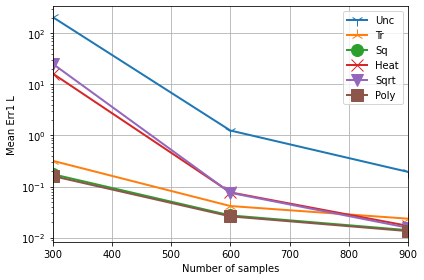

In [8]:
# %matplotlib qt

# Plot error 1
err_A, err_L, err_lamb = est_errs1(As_hat, lamds_hat, A, lambdas)
mean_err = np.mean(err_A, 2)
mean_err_L = np.mean(err_L, 2)
mean_err_lam = np.mean(err_lamb, 2)
plot_err(MM[:], models, mean_err_L[:,:], 'Mean Err1 L')

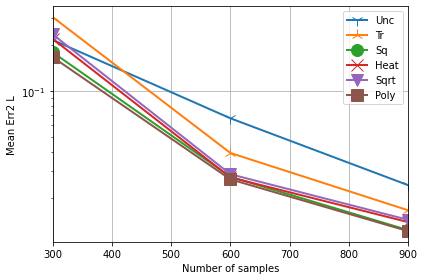

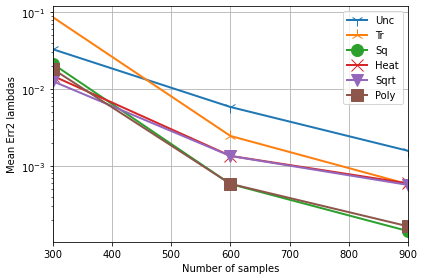

In [9]:
err_A, err_L, err_lamb = est_errs2(As_hat, lamds_hat, A, lambdas)
mean_err = np.mean(err_A, 2)
mean_err_L = np.median(err_L, 2)
mean_err_lam = np.mean(err_lamb, 2)
plot_err(MM, models, mean_err_L, 'Mean Err2 L')
plot_err(MM, models, mean_err_lam, 'Mean Err2 lambdas')

### Plot spectrum

IndexError: index 5 is out of bounds for axis 1 with size 5

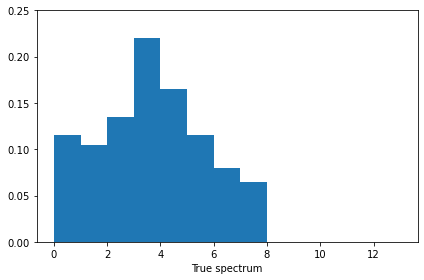

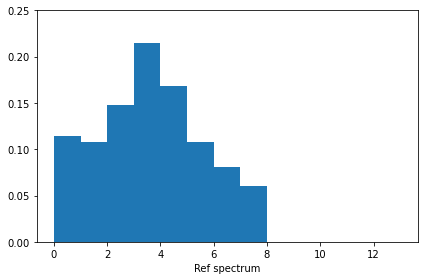

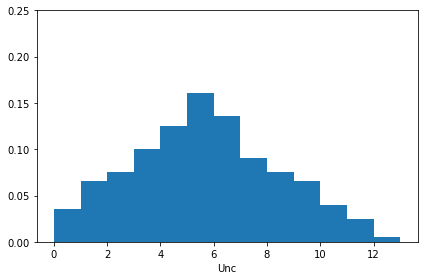

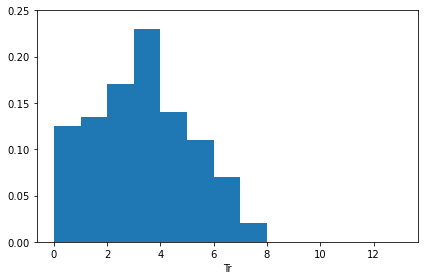

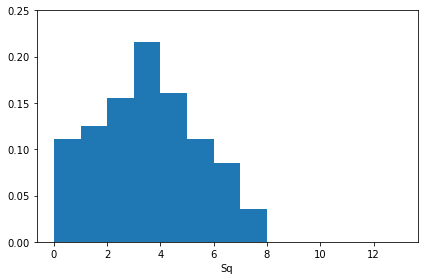

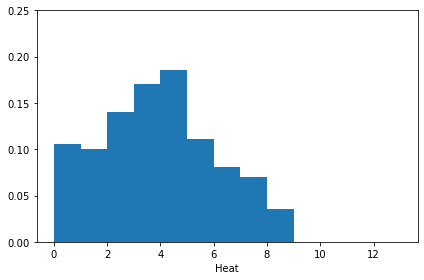

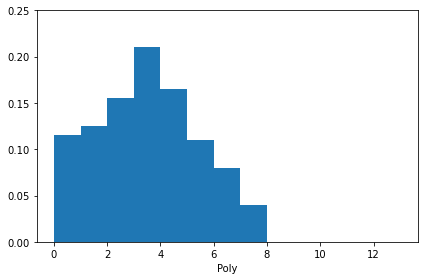

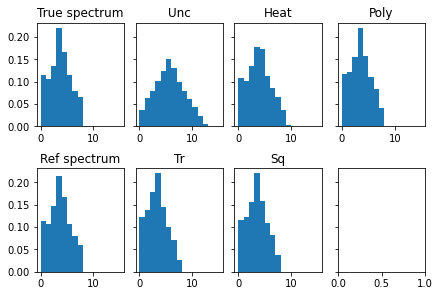

In [20]:
M = 800
idx = np.where(MM == M)[0]

# First signals
plot_spectrum(models, lambdas, lambdas0, np.squeeze(lamds_hat[:,:,idx,0]), M)

lamds_aux = np.concatenate(lamds_hat[:,:,idx,:].transpose(0, 3, 1, 2), axis=0)
plot_spectrum(models, lambdas, lambdas0, np.squeeze(lamds_aux), M)


In [14]:
# Save data
# models_aux = [{'name': model['name'], 'fmt': model['fmt'], 'regs': model['regs']}
#                 for model in models]
# data = {
#     'A': A,
#     'lambdas': lambdas,
#     'lambdas0': lambdas0,
#     'As_hat': As_hat,
#     'lamds_hat': lamds_hat,
#     'MM': MM,
#     'models': models_aux
# }
# file = 'constraints_{}covs_{}iters'.format(n_covs, iters)
# np.save('results/constraints/' + file, data)

In [19]:
# # Load data
# file = 'results/constraints/constraints_100covs_200iters.npy'
# data = np.load(file, allow_pickle=True).item()
# models = data['models']

# A = data['A']
# lambdas = data['lambdas']
# lambdas0 = data['lambdas0']
# As_hat = data['As_hat']
# lamds_hat = data['lamds_hat']
# MM = data['MM']
# models = data['models']